# Модуль 4 Разработка модели

In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

font = 16
sns.set(font_scale=1.4)

In [31]:
df_train_l = pd.read_csv('df_train_l.csv')
df_train_l

,schema_3,schema_6,schema_4,schema_5,index,filename,defect_type,side,schema_3_lag_1,schema_3_lag_2,...,schema_4_lag_-1,schema_4_lag_-2,schema_5_lag_1,schema_5_lag_2,schema_5_lag_-1,schema_5_lag_-2,clusters_KMeans,clusters_DBSCAN,clusters_AgglomerativeClustering,clusters_SpectralClustering
0,0.0,0.0,0.0,0.0,1,SOP1.dat,-1,-1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0
1,0.0,0.0,0.0,0.0,2,SOP1.dat,-1,-1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0
2,0.0,0.0,0.0,0.0,3,SOP1.dat,-1,-1,0.0,0.0,...,0.0,27.2,0.0,0.0,0.0,14.2,0,0,1,0
3,0.0,0.0,0.0,0.0,4,SOP1.dat,-1,-1,0.0,0.0,...,27.2,27.8,0.0,0.0,14.2,9.6,0,0,1,0
4,190.2,15.6,27.2,14.2,5,SOP1.dat,-1,-1,0.0,0.0,...,27.8,28.6,0.0,0.0,9.6,7.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3114,0.0,23.6,167.0,113.6,1034,SOP3.dat,-1,-1,0.0,0.0,...,155.6,145.0,124.2,123.8,101.0,86.0,0,0,0,0
3115,0.0,27.4,155.6,101.0,1035,SOP3.dat,-1,-1,0.0,0.0,...,145.0,137.4,113.6,124.2,86.0,69.4,0,0,0,0
3116,0.0,32.4,145.0,86.0,1036,SOP3.dat,-1,-1,0.0,0.0,...,137.4,133.4,101.0,113.6,69.4,55.8,0,0,0,0
3117,0.0,38.4,137.4,69.4,1037,SOP3.dat,-1,-1,0.0,0.0,...,133.4,0.0,86.0,101.0,55.8,0.0,0,0,1,0


## 1 РАЗБИЕНИЕ ДАННЫХ НА ОБУЧАЮЩУЮ И ПРОВЕРОЧНУЮ ВЫБОРКУ

Загрузка публичной тестовой выборки и подготовка

In [32]:
test_filenames = ['К3.dat', 'К16.dat', 'К22.dat', 'К24.dat', 'К28.dat']
test_data = {}
for filename in test_filenames:
    path_to_data = 'C:/Users/Vladlen/Documents/Python/AtomSkills/data/Results/' + filename
    f = open(path_to_data).read()
    test_data[filename] = f.split('\n')
    
for data in test_filenames:
    test_data[data] = test_data[data][1:-1]
    
df_test = pd.DataFrame(columns=['filename', 'index'] + [f'schema_{i}' for i in range(1, 17)])
for data in test_filenames:
    for values in test_data[data]:
        values_list = values.split(' ')
        values_list = list(map(int, values_list))
        df_test.loc[len(df_test), :] = [data] + values_list

numeric_columns = [col for col in df_test.columns if col not in ['filename', 'index']]
df_test[numeric_columns] = df_test[numeric_columns].astype('int')
        
window = 5
df_test_rolled = []
for filename in test_filenames:
    df_test_rolled.append(df_test[df_test.filename == filename][numeric_columns].rolling(window=window).mean().fillna(value=0))
df_test_rolled = pd.concat(df_test_rolled)
df_test_rolled[['filename', 'index']] = df_test[['filename', 'index']]

targets_test = {}
target_filenames = ['k3.csv', 'k16.csv', 'k22.csv', 'k24.csv', 'k28.csv']
df_target = pd.DataFrame()
for k in range(len(target_filenames)):
    df_target_temp = pd.read_csv('data/Target/' + target_filenames[k])
    df_target_temp['file'] = [target_filenames[k]] * len(df_target_temp)
    df_target_temp['link'] = [test_filenames[k]] * len(df_target_temp)
    df_target = pd.concat([df_target, df_target_temp])
    
df_target[['Начало дефекта', 'Длина дефекта']].iloc[df_target[['Начало дефекта', 'Длина дефекта']].dropna().index] = df_target[['Начало дефекта', 'Длина дефекта']].iloc[df_target[['Начало дефекта', 'Длина дефекта']].dropna().index].astype('int')

df_test_rolled.loc[:, 'defect_type'] = [-1] * len(df_test_rolled)
df_test_rolled.loc[:, 'side'] = [-1] * len(df_test_rolled)
for k in range(len(df_target)):
    row = df_target.iloc[k]
    if row['Тип дефекта'] != 'T':
        defect_start = row['Начало дефекта'] + 50
        defect_length = row['Длина дефекта'].astype('int')
        defect_end = defect_start + row['Длина дефекта'].astype('int')
        idx = df_test_rolled[(df_test_rolled.filename == row.link) & (df_test_rolled[df_test_rolled.filename == row.link]['index'] > defect_start) & (df_test_rolled[df_test_rolled.filename == row.link]['index'] <= defect_end)].index
        if defect_end > df_test_rolled[df_test_rolled.filename == row.link]['index'].iloc[-1]:
            idx = [i for i in range(defect_start, len(df_test_rolled[df_test_rolled.filename == row.link]))]
            defect_length = df_test_rolled[df_test_rolled.filename == row.link].iloc[-1]['index'] - defect_start
            df_test_rolled.loc[idx, 'side'] = ['A'] * defect_length if row['Сторона'] == 'A' else ['B'] * defect_length
            df_test_rolled.loc[idx, 'defect_type'] = ['L'] * defect_length
        else:
            idx = df_test_rolled[(df_test_rolled.filename == row.link) & (df_test_rolled[df_test_rolled.filename == row.link]['index'] > defect_start) & (df_test_rolled[df_test_rolled.filename == row.link]['index'] <= defect_end)].index
            df_test_rolled.loc[idx, 'side'] = ['A'] * defect_length if row['Сторона'] == 'A' else ['B'] * defect_length
            df_test_rolled.loc[idx, 'defect_type'] = ['L'] * defect_length
    else:
        defect_start = row['Начало дефекта'] + 50
        defect_length = 1
        defect_end = defect_start + defect_length
        idx = df_test_rolled[(df_test_rolled.filename == row.link) & (df_test_rolled[df_test_rolled.filename == row.link]['index'] > defect_start) & (df_test_rolled[df_test_rolled.filename == row.link]['index'] <= defect_end)].index
        df_test_rolled.loc[idx, 'side'] = ['A'] * defect_length if row['Сторона'] == 'A' else ['B'] * defect_length
        df_test_rolled.loc[idx, 'defect_type'] = ['T'] * defect_length
        
l_schemas = ['schema_3', 'schema_6', 'schema_4', 'schema_5']
df_test_l = df_test_rolled[l_schemas + ['index', 'filename', 'defect_type', 'side']]
for schema in l_schemas:
    df_test_l[f'{schema}_lag_1'] = df_test_l[schema].shift(1)
    df_test_l[f'{schema}_lag_2'] = df_test_l[schema].shift(2)
    df_test_l[f'{schema}_lag_-1'] = df_test_l[schema].shift(-1)
    df_test_l[f'{schema}_lag_-2'] = df_test_l[schema].shift(-2)
df_test_l.fillna(value=0, inplace=True)

C:\Users\Vladlen\anaconda3\lib\site-packages\pandas\core\indexing.py:1851: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)
C:\Users\Vladlen\AppData\Local\Temp/ipykernel_3060/2794492758.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_l[f'{schema}_lag_1'] = df_test_l[schema].shift(1)
C:\Users\Vladlen\AppData\Local\Temp/ipykernel_3060/2794492758.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

Для обучения принято решение использовать файлы SOP1.dat и SOP2.dat, для проверки - файл SOP3.dat

In [36]:
df_train_l

,schema_3,schema_6,schema_4,schema_5,index,filename,defect_type,side,schema_3_lag_1,schema_3_lag_2,...,schema_4_lag_-1,schema_4_lag_-2,schema_5_lag_1,schema_5_lag_2,schema_5_lag_-1,schema_5_lag_-2,clusters_KMeans,clusters_DBSCAN,clusters_AgglomerativeClustering,clusters_SpectralClustering
0,0.0,0.0,0.0,0.0,1,SOP1.dat,-1,-1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0
1,0.0,0.0,0.0,0.0,2,SOP1.dat,-1,-1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0
2,0.0,0.0,0.0,0.0,3,SOP1.dat,-1,-1,0.0,0.0,...,0.0,27.2,0.0,0.0,0.0,14.2,0,0,1,0
3,0.0,0.0,0.0,0.0,4,SOP1.dat,-1,-1,0.0,0.0,...,27.2,27.8,0.0,0.0,14.2,9.6,0,0,1,0
4,190.2,15.6,27.2,14.2,5,SOP1.dat,-1,-1,0.0,0.0,...,27.8,28.6,0.0,0.0,9.6,7.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3114,0.0,23.6,167.0,113.6,1034,SOP3.dat,-1,-1,0.0,0.0,...,155.6,145.0,124.2,123.8,101.0,86.0,0,0,0,0
3115,0.0,27.4,155.6,101.0,1035,SOP3.dat,-1,-1,0.0,0.0,...,145.0,137.4,113.6,124.2,86.0,69.4,0,0,0,0
3116,0.0,32.4,145.0,86.0,1036,SOP3.dat,-1,-1,0.0,0.0,...,137.4,133.4,101.0,113.6,69.4,55.8,0,0,0,0
3117,0.0,38.4,137.4,69.4,1037,SOP3.dat,-1,-1,0.0,0.0,...,133.4,0.0,86.0,101.0,55.8,0.0,0,0,1,0


In [105]:
train = df_train_l[(df_train_l.filename == 'SOP1.dat') | (df_train_l.filename == 'SOP2.dat')][[col for col in df_train_l.columns if 'schema' in col] + ['side', 'defect_type']]
valid = df_train_l[(df_train_l.filename == 'SOP3.dat')][[col for col in df_train_l.columns if 'schema' in col] + ['side', 'defect_type']]
test = df_test_l[[col for col in df_test_l.columns if 'schema' in col] + ['side', 'defect_type', 'filename', 'index']]
train.shape, valid.shape, test.shape

((2081, 22), (1038, 22), (5141, 24))

<p> Для каждой стороны будет использована своя пара схем прозвучивания и модель: </p>
<p> - Для стороны A: схема 3 и 6 </p>
<p> - Для стороны B: схема 4 и 5 </p>

In [125]:
models = [LogisticRegression(), DecisionTreeClassifier(random_state=42), 
          RandomForestClassifier(random_state=42), CatBoostClassifier(random_seed=42, verbose=0)]
models_names = ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'CatBoostClassifier']

blind_predictions = {}
test_values = {}
for side in ['A', 'B']:
    blind_predictions[side] = {}
    print('Side: ', side)
    
    if side == 'A':
        schemas = [col for col in train.columns if 'schema_3' in col] + [col for col in train.columns if 'schema_6' in col]
    else:
        schemas = [col for col in train.columns if 'schema_4' in col] + [col for col in train.columns if 'schema_5' in col]
    print('Features: ', schemas)

    x_train = train[schemas].values
    x_valid = valid[schemas].values
    x_test = test[schemas].values
    
    if side == 'A':
        y_train = train['side'].apply(lambda x: 1 if x == 'A' else 0)
        y_valid = valid['side'].apply(lambda x: 1 if x == 'A' else 0)
        y_test = test['side'].apply(lambda x: 1 if x == 'A' else 0)
    else:
        y_train = train['side'].apply(lambda x: 1 if x == 'B' else 0)
        y_valid = valid['side'].apply(lambda x: 1 if x == 'B' else 0)
        y_test = test['side'].apply(lambda x: 1 if x == 'B' else 0)
    test_values[side] = y_test.values

    for k in range(len(models)):
        model = models[k]
        
        if models_names[k] == 'LogisticRegression':
            scaler = StandardScaler()
            x_train = scaler.fit_transform(x_train)
            x_valid = scaler.transform(x_valid)
            x_test = scaler.transform(x_test)
        
        model.fit(x_train, y_train)
        y_pred = model.predict(x_valid)
        y_pred_test = model.predict(x_test)
        blind_predictions[side][models_names[k]] = y_pred_test
        
        print('Model: ', models_names[k])
        print('Accuracy score validation: ', accuracy_score(y_valid, y_pred))
        print('Accuracy score test: ', accuracy_score(y_test, y_pred_test))
        print('Confusion matrix validation: ', confusion_matrix(y_valid, y_pred))
        print('Confusion matrix test: ', confusion_matrix(y_test, y_pred_test))
        print('=' * 50)

Side:  A
Features:  ['schema_3', 'schema_3_lag_1', 'schema_3_lag_2', 'schema_3_lag_-1', 'schema_3_lag_-2', 'schema_6', 'schema_6_lag_1', 'schema_6_lag_2', 'schema_6_lag_-1', 'schema_6_lag_-2']
Model:  LogisticRegression
Accuracy score validation:  0.9691714836223507
Accuracy score test:  0.9418401089282241
Confusion matrix validation:  [[947   0]
 [ 32  59]]
Confusion matrix test:  [[4791   45]
 [ 254   51]]
Model:  DecisionTreeClassifier
Accuracy score validation:  0.9556840077071291
Accuracy score test:  0.9192764053686053
Confusion matrix validation:  [[936  11]
 [ 35  56]]
Confusion matrix test:  [[4674  162]
 [ 253   52]]
Model:  RandomForestClassifier
Accuracy score validation:  0.9518304431599229
Accuracy score test:  0.941062050184789
Confusion matrix validation:  [[937  10]
 [ 40  51]]
Confusion matrix test:  [[4780   56]
 [ 247   58]]
Model:  CatBoostClassifier
Accuracy score validation:  0.9566473988439307
Accuracy score test:  0.9397004473837774
Confusion matrix validation:

Визуализация полученных значений

No handles with labels found to put in legend.


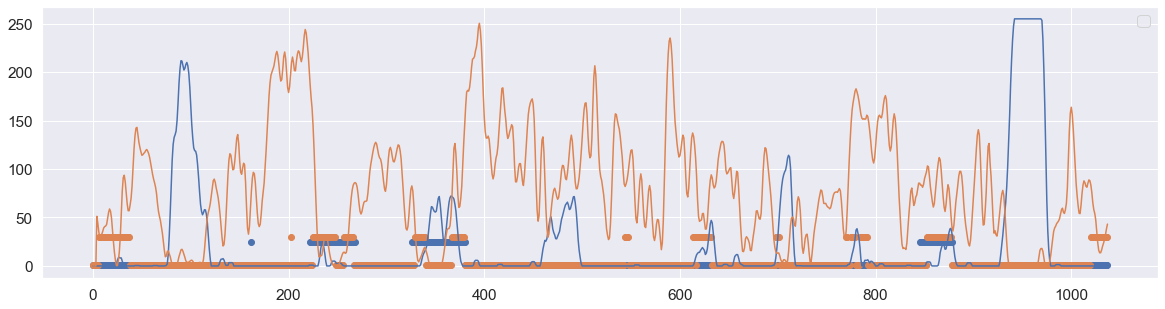

In [130]:
plt.figure(figsize=(20, 5))
side = 'A'
plt.plot(range(len(valid)), valid['schema_3'])
plt.plot(range(len(valid)), valid['schema_6'])
plt.scatter(range(len(valid)), 
            25**y_valid)
plt.scatter(range(len(valid)), 
            30**y_pred)
plt.legend(fontsize=font)

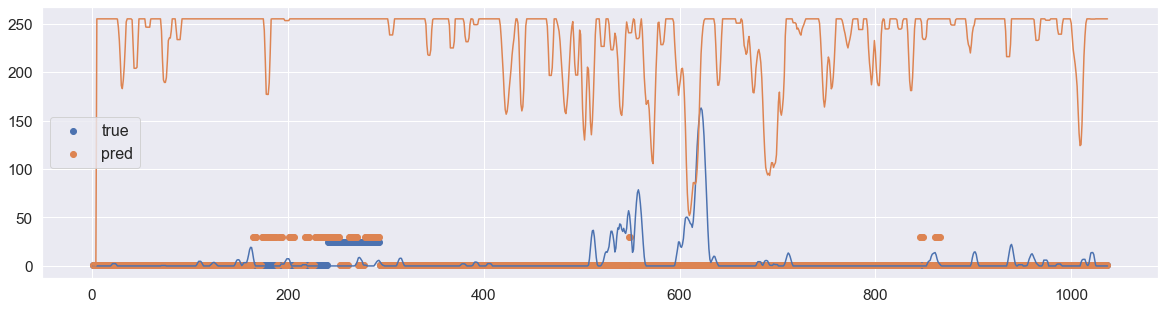

In [159]:
plt.figure(figsize=(20, 5))
side = 'A'
filename = 'К16.dat'
plt.plot(test[test.filename == filename]['index'], test[test.filename == filename]['schema_3'])
plt.plot(test[test.filename == filename]['index'], test[test.filename == filename]['schema_6'])
plt.scatter(test[test.filename == filename]['index'], 
            25**test_values[side][test[test.filename == filename]['index'].values].astype('int'), label='true')
plt.scatter(test[test.filename == filename]['index'], 
            30**blind_predictions[side]['CatBoostClassifier'][test[test.filename == filename]['index'].values].astype('int'), label='pred')
plt.legend(fontsize=font)

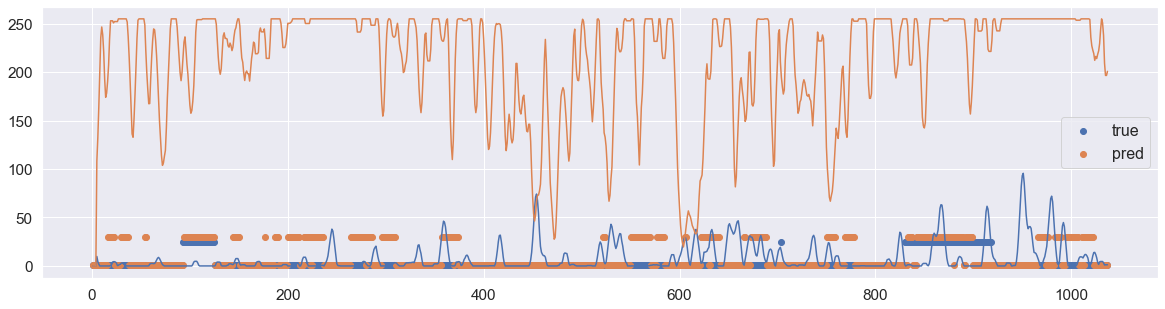

In [158]:
plt.figure(figsize=(20, 5))
side = 'B'
filename = 'К16.dat'
plt.plot(test[test.filename == filename]['index'], test[test.filename == filename]['schema_4'])
plt.plot(test[test.filename == filename]['index'], test[test.filename == filename]['schema_5'])
plt.scatter(test[test.filename == filename]['index'], 
            25**test_values[side][test[test.filename == filename]['index'].values].astype('int'), label='true')
plt.scatter(test[test.filename == filename]['index'], 
            30**blind_predictions[side]['CatBoostClassifier'][test[test.filename == filename]['index'].values].astype('int'), label='pred')
plt.legend(fontsize=font)